<a href="https://colab.research.google.com/github/YazzRz/TFM_Ana_Rozo_Georeferenciacion_Violencia_Machista/blob/main/Limpieza_de_archivos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import glob
import numpy as np

# Archivos de Control
archivos = [
    "ABC_1_archivoControl.csv",
    "ABC_2_archivoControl.csv",
    "ABC_3_archivoControl.csv",
    "ABC_4_archivoControl.csv",
    "EL_MUNDO_1_archivoControl.csv",
    "EL_MUNDO_2_archivoControl.csv",
    "LARAZON_1_archivoControl.csv",
    "LARAZON_1_archivoControl.csv",
    "PUBLICO_archivoControl.csv",
]

# 1. Función para cargar cualquier archivo en un esquema común
def cargar_archivo(ruta):
    if ruta.endswith(".csv"):
        df = pd.read_csv(ruta)
        df = df.rename(columns={df.columns[0]: "data"})
    elif ruta.endswith(".xlsx"):
        df = pd.read_excel(ruta)
        df = df.rename(columns={df.columns[0]: "data"})
    else:
        raise ValueError("Formato no soportado")
    return df[["data"]]

# 2. Cargar y unir todo
df_total = pd.concat([cargar_archivo(f) for f in archivos], ignore_index=True)

# 3. Limpiar textos
# se debe arreglar problema de acentos "ArtÃ­culo" → "Artículo" para no tener problemas al consolidar los datos de los archivos
df_total["data"] = df_total["data"].str.replace("ArtÃ­culo", "Artículo", regex=False)

# 4. Separar en dos columnas
df_total[["Fecha", "Articulo"]] = df_total["data"].str.split(",", n=1, expand=True)

# Limpiar id y url
df_total["id"] = df_total["Fecha"].str.replace("Fecha:", "").str.strip()
df_total["url"] = df_total["Articulo"].str.replace("Artículo:", "").str.strip()

# 5. Nos quedamos solo con id y url
df_final = df_total[["id", "url"]].copy()

# 6. Identificar el periódico según la URL
def identificar_periodico(url):
    if "elpais.com" in url:
        return "elpais"
    elif "eltiempo.com" in url:
        return "eltiempo"
    elif "elespectador.com" in url:
        return "espectador"
    elif "heraldo.com" in url or "elheraldo.co" in url:
        return "heraldo"
    elif "elcolombiano.com" in url:
        return "elcolombiano"
    elif "eluniversal.com" in url:
        return "eluniversal"
    elif "abc.es" in url:
        return "abc"
    elif "elmundo.es" in url:
        return "elmundo"
    elif "larazon.es" in url:
        return "larazon"
    elif "publico.es" in url:
        return "publico"
    else:
        return "desconocido"

df_final["periodico"] = df_final["url"].apply(identificar_periodico)

# Ver resultado
print(df_final.head(15))



                id                                                url  \
0   20250423112537  https://web.archive.org/web/20250423112537/htt...   
1   20250423223553  https://web.archive.org/web/20250423223553/htt...   
2   20250423223553  https://web.archive.org/web/20250423223553/htt...   
3   20250423223553  https://web.archive.org/web/20250423223553/htt...   
4   20250426074402  https://web.archive.org/web/20250426074402/htt...   
5   20250426074402  https://web.archive.org/web/20250426074402/htt...   
6   20250720161801  https://web.archive.org/web/20250720161801/htt...   
7   20250430173537  https://web.archive.org/web/20250430173537/htt...   
8   20250430173537  https://web.archive.org/web/20250430173537/htt...   
9   20250611150643  https://web.archive.org/web/20250611150643/htt...   
10  20250611150643  https://web.archive.org/web/20250611150643/htt...   
11  20250612185845  https://web.archive.org/web/20250612185845/htt...   
12  20250810100509  https://web.archive.org/web/202

In [5]:
import re

# 1. Ajustar las URLs para vincularlo con la página de web.archive y poder hacer la lectura de los periódicos desde allí
df_final.loc[:, "url"] = df_final.apply(
    lambda fila: fila["url"]
    if str(fila["url"]).startswith("https://web.archive.org")
    else f"https://web.archive.org/web/{fila['id']}/{fila['url']}",
    axis=1
)

# 2. Eliminar duplicaciones múltiples del patrón
df_final.loc[:, "url"] = df_final.apply(
    lambda fila: re.sub(
        f"(https://web.archive.org/web/{fila['id']}/)+",
        f"https://web.archive.org/web/{fila['id']}/",
        str(fila["url"])
    ),
    axis=1
)

# 3. Construir nuevo ID
# Prefijo según dominio
def obtener_prefijo(url):
    if ".co" in url:
        return "CO"
    elif ".es" in url:
        return "ESP"
    else:
        return "OTRO"  # por si hay más casos

df_final["prefijo"] = df_final["url"].apply(obtener_prefijo)

# Generar id numerado por repeticiones
df_final["id"] = (
    df_final.groupby(["prefijo", "id"]).cumcount().astype(str)
    .radd("_")
    .radd(df_final["id"])
    .radd(df_final["prefijo"] + "_")
)

# 4. Quitar columna auxiliar
df_final = df_final[["id", "url", "periodico"]]
print(df_final.columns)

# Ver primeros resultados
print(df_final.head(20))


Index(['id', 'url', 'periodico'], dtype='object')
                      id                                                url  \
0   ESP_20250423112537_0  https://web.archive.org/web/20250423112537/htt...   
1   ESP_20250423223553_0  https://web.archive.org/web/20250423223553/htt...   
2   ESP_20250423223553_1  https://web.archive.org/web/20250423223553/htt...   
3   ESP_20250423223553_2  https://web.archive.org/web/20250423223553/htt...   
4   ESP_20250426074402_0  https://web.archive.org/web/20250426074402/htt...   
5   ESP_20250426074402_1  https://web.archive.org/web/20250426074402/htt...   
6   ESP_20250720161801_0  https://web.archive.org/web/20250720161801/htt...   
7   ESP_20250430173537_0  https://web.archive.org/web/20250430173537/htt...   
8   ESP_20250430173537_1  https://web.archive.org/web/20250430173537/htt...   
9   ESP_20250611150643_0  https://web.archive.org/web/20250611150643/htt...   
10  ESP_20250611150643_1  https://web.archive.org/web/20250611150643/htt...   
11

In [2]:
import pandas as pd
import os

# === 1. Cargar archivo de errores ===
errores = pd.read_csv("ERRORES.csv")  # Cambia la ruta si está en otra carpeta

# Renombrar columnas para consistencia
errores = errores.rename(columns={"ID_NOTICIA": "id", "URL": "url"})

# === 2. Crear columna 'periodico' ===
def obtener_periodico(url):
    if pd.isna(url):
        return "desconocido"
    if "elpais.com" in url:
        return "elpais"
    elif "eltiempo.com" in url:
        return "eltiempo"
    elif "elespectador.com" in url:
        return "espectador"
    elif "heraldo.com" in url or "elheraldo.co" in url:
        return "heraldo"
    elif "elcolombiano.com" in url:
        return "elcolombiano"
    elif "eluniversal.com" in url:
        return "eluniversal"
    elif "abc.es" in url:
        return "abc"
    elif "elmundo.es" in url:
        return "elmundo"
    elif "larazon.es" in url:
        return "larazon"
    elif "publico.es" in url:
        return "publico"
    else:
        return "desconocido"

errores["periodico"] = errores["url"].apply(obtener_periodico)

# === 3. Cargar df_final si existe, si no trabajar sólo con errores ===
if os.path.exists("df_final.csv"):
    df_final = pd.read_csv("df_final.csv")
    df_union = pd.concat([df_final, errores], ignore_index=True)
else:
    df_union = errores.copy()

# === 4. Guardar el resultado actualizado ===
df_union.to_csv("df_final.csv", index=False)

print(df_union.head(20))
print(df_union["periodico"].value_counts())


              ID_noticia                                                url  \
0    CO_20210119232245_0  https://web.archive.org/web/20210119232245/htt...   
1    CO_20160119082949_1  https://web.archive.org/web/20160119082949/htt...   
2    CO_20171209064606_0  https://web.archive.org/web/20171209064606/htt...   
3    CO_20180918211224_0  https://web.archive.org/web/20180918211224/htt...   
4    CO_20200310202701_0  https://web.archive.org/web/20200310202701/htt...   
5   ESP_20230826090631_1  https://web.archive.org/web/20230826090631/htt...   
6    CO_20241018235343_1  https://web.archive.org/web/20241018235343/htt...   
7    CO_20231215235053_0  https://web.archive.org/web/20231215235053/htt...   
8    CO_20181228012741_0  https://web.archive.org/web/20181228012741/htt...   
9    CO_20181026153752_0  https://web.archive.org/web/20181026153752/htt...   
10  ESP_20231127205411_6  https://web.archive.org/web/20231127205411/htt...   
11   CO_20190331123013_2  https://web.archive.org/we

In [3]:
# Exportar a CSV
df_union.to_csv("consolidado_url_3.csv", index=False, encoding="utf-8")

,periodico,cantidad
0,elmundo,4948
1,publico,279
2,heraldo,86
3,espectador,32
4,elpais,31
5,elcolombiano,29
6,abc,22
7,eluniversal,19
8,eltiempo,12
9,desconocido,9


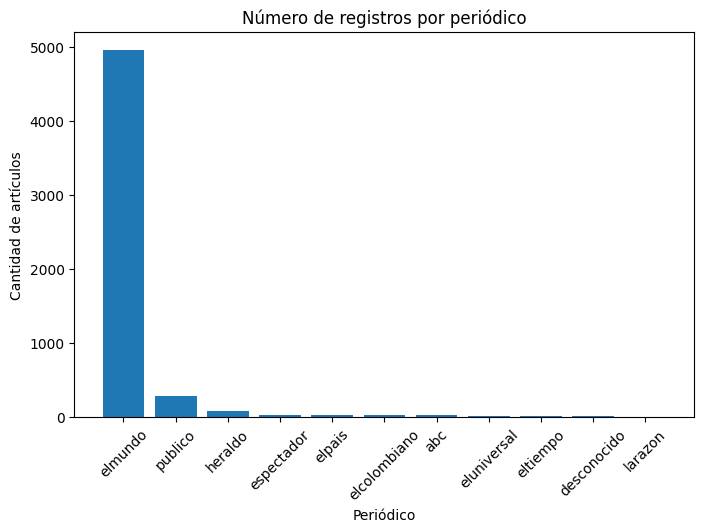

In [8]:
import matplotlib.pyplot as plt

# Conteo de registros por periódico
conteo_periodicos = df_union["periodico"].value_counts().reset_index()
conteo_periodicos.columns = ["periodico", "cantidad"]

# Mostrar tabla en Colab
conteo_periodicos_df = pd.DataFrame(conteo_periodicos)
display(conteo_periodicos_df)

# Gráfica de barras
plt.figure(figsize=(8,5))
plt.bar(conteo_periodicos["periodico"], conteo_periodicos["cantidad"])
plt.title("Número de registros por periódico")
plt.xlabel("Periódico")
plt.ylabel("Cantidad de artículos")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Seleccionar 15 filas aleatorias de manera fija (replicable con random_state)
df_prueba = df_final.sample(n=15, random_state=42)

df_prueba.to_csv("consolidado_prueba.csv", index=False, encoding="utf-8")
